(sec:reinforcement-learning)=
# 強化学習の基礎

強化学習とは、何らかの目的を達成するために、「行動」と「評価」を繰り返しながら、より良い行動を取ることを目指す機械学習法である。

これまで取り扱ってきた教師あり学習が「正解に近づく」ように学習を行うのに対し、強化学習は、**報酬が最大となる**ように学習を行う。

今回は、「多腕バンディット問題」を題材に、強化学習の基礎について紹介する。

In [1]:
"""
下準備のコード
"""

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# グラフの設定
matplotlib.rcParams["figure.dpi"] = 150
sns.set(style="white", palette="colorblind")

In [2]:
try:
    from myst_nb import glue
except:
    glue = lambda _: _

## 多腕バンディット問題

**多腕バンディット問題**とは、スロットゲームを題材に、得られる報酬の量を最大にする問題である。今、スロットが複数台あり、それぞれがどの程度の確率で当たりを出すかは未知である。このような状況下で、スロットを決まった回数だけ回して、当たり確率を推定しながら、より多くの当たりを出すスロットを回す。

この問題では、**当たり確率の推定精度を上げる**ことと、**当たりが多く出そうなスロットを回す**という二つの問題を同時に解く必要がある。本資料では、これらの目的を目指す行動を、それぞれ**探査**と**知識利用**と呼ぶ。

探査と知識利用は、相反する行動で、より当たり確率の推定精度を上げようとすれば、例えば、一見当たりが出なさそうにみえるスロットも、もう少し回した方が良い可能性がある。一方で、推定精度の向上に拘泥しすぎると、当たりが多く出そうなスロットを回す回数が減ってしまい、結果として得られる報酬が減ってしまう。

### スロットゲームの実装

まずは、多腕バンディット問題を扱うために、スロットゲームを実装してみる。スロット台のアームを表わす `SlotArm`というクラスを以下のように実装する。

In [3]:
import numpy as np


class SlotArm(object):
    """スロットアームを表わすクラス"""

    def __init__(self, ratio=0.5, seed=None):
        self.ratio = ratio
        self.rng = np.random.RandomState(seed)

    def roll(self):
        if self.rng.uniform(0.0, 1.0) < self.ratio:
            return True
        else:
            return False

この`SlotArm`クラスを配列として、スロット台を複数用意する。以下では、5台のスロット台を用意し、それらが当たりを出す確率が0.1から0.2刻みで0.9までであるとする (**これは実際には未知の値である**)。

In [4]:
# スロットアームの数
n_arms = 5

# 0.1-0.9までの当たり確率を0.2刻みで設定
# その後、順番をランダムに入れ替える
ratios = np.linspace(0.1, 0.9, n_arms, endpoint=True)
ratios = np.random.permutation(ratios)

# 用意した当たり確率を用いてスロットアームをインスタンス化
arms = [None] * n_arms
for i, ratio in enumerate(ratios):
    arms[i] = SlotArm(ratio=ratio)

# スロットを回す回数
n_play = 20000

# 描画に用いる変数
xs = np.arange(n_play) + 1

In [5]:
glue("n_arms", n_arms, display=False)
glue("avg_ratio", np.mean(ratios), display=False)
glue("best_ratio", np.max(ratios), display=False)
glue("n_play", n_play, display=False)

### ランダムにスロットを回す

では、上記の問題設定で、ランダムに{glue:}`n_arms`つのスロット台のいずれかを回した場合に、どの程度の当たりが出るかを見てみよう。以下の実験では{glue:}`n_play`回スロットをプレイできるとして実験をしてみる。

In [6]:
history = []
for i in range(n_play):
    # ランダムに1つのスロットを選ぶ
    k = np.random.randint(0, n_arms)
    # 当たり外れを記録
    if arms[k].roll():
        history.append(1.0)
    else:
        history.append(0.0)

history = np.array(history)
accum = np.cumsum(history)

E_rand = accum / xs  # 当たり確率
S_rand = np.sqrt((history - E_rand) ** 2.0 / xs)  # 推定当たり確率の分散

In [7]:
glue("random_ratio", E_rand[-1], display=False)

**結果: ランダムにスロットを回す**

- 当たり確率: {glue:text}`random_ratio:.3f`

以下には、横軸にスロットを回した回数を取り、当たり確率とその推定値分散をプロットしたものを示す。

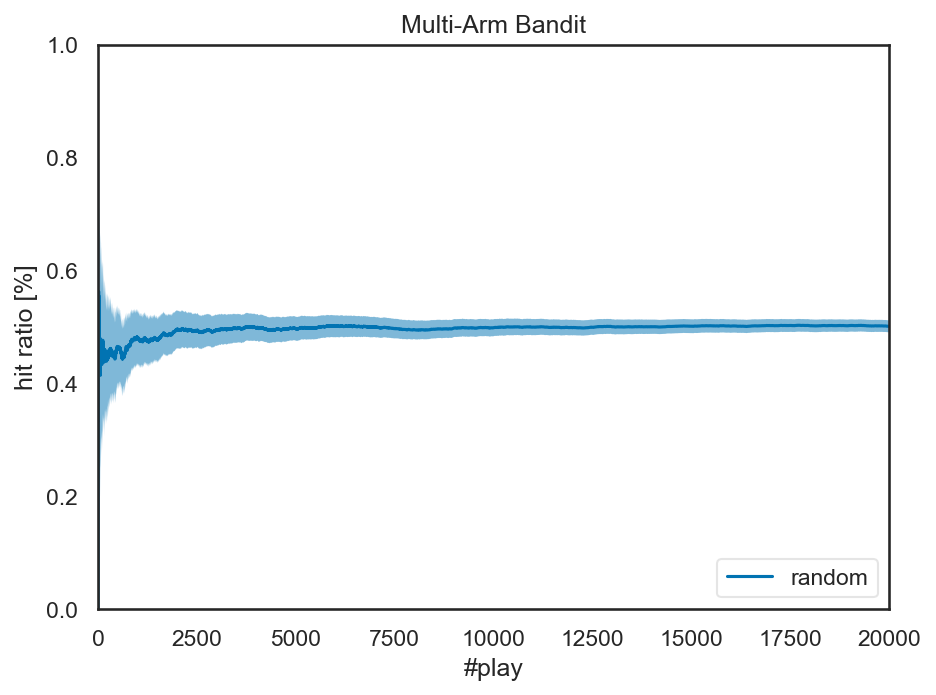

In [8]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

この結果から分かる通り、ランダムに回す場合には、得られる報酬は、当たり確率の{glue:text}`avg_ratio:.2f`程度に張り付いていることが分かる。回し方を工夫することで、この当たり確率を上げることをできるかがポイントとなる。

## 一番当たっているスロットを回す (貪欲法)

報酬を増やすためにあり得そうな方法は、今、一番当たっているスロットを常に回す、という方法である。この方式を**貪欲法**と呼ぶ。

以下に、各スロットの現在の当たり確率を保存しておいて、それが最大になるものを回すようにプログラムを示す。

ただし、最初の数回は当たり確率が安定しない可能性があるので、最初の10%は、ランダムに回している。このように最初の何回かを乱数による影響を除去するためにランダム試行する操作を**バーンイン**と呼ぶ。

In [9]:
# バーンインの回数
n_burnin = n_play // 10

# 当たり外れの履歴、当たり回数、プレイ回数を記録
history = []
n_hit_of_arm = [0] * len(arms)
n_play_of_arm = [0] * len(arms)
for i in range(n_play):
    if i < n_burnin:
        # バーンイン中ならランダムに回す
        k = np.random.randint(0, n_arms)
    else:
        # そうでなければ、当たり確率が最大のものを回す
        rs = [(h / p if p != 0 else 1.0) for h, p in zip(n_hit_of_arm, n_play_of_arm)]
        k = np.argmax(rs)

    if arms[k].roll():
        history.append(1.0)
        n_hit_of_arm[k] += 1
    else:
        history.append(0.0)

    n_play_of_arm[k] += 1

history = np.array(history)
accum = np.cumsum(history)

E_greedy = accum / xs
S_greedy = np.sqrt((history - E_greedy) ** 2.0 / xs)

In [10]:
glue("greedy_ratio", E_greedy[-1], display=False)

**結果: 貪欲法**

- 当たり確率: {glue:text}`greedy_ratio:.3f`

以下には得られた平均報酬の比較を示す。

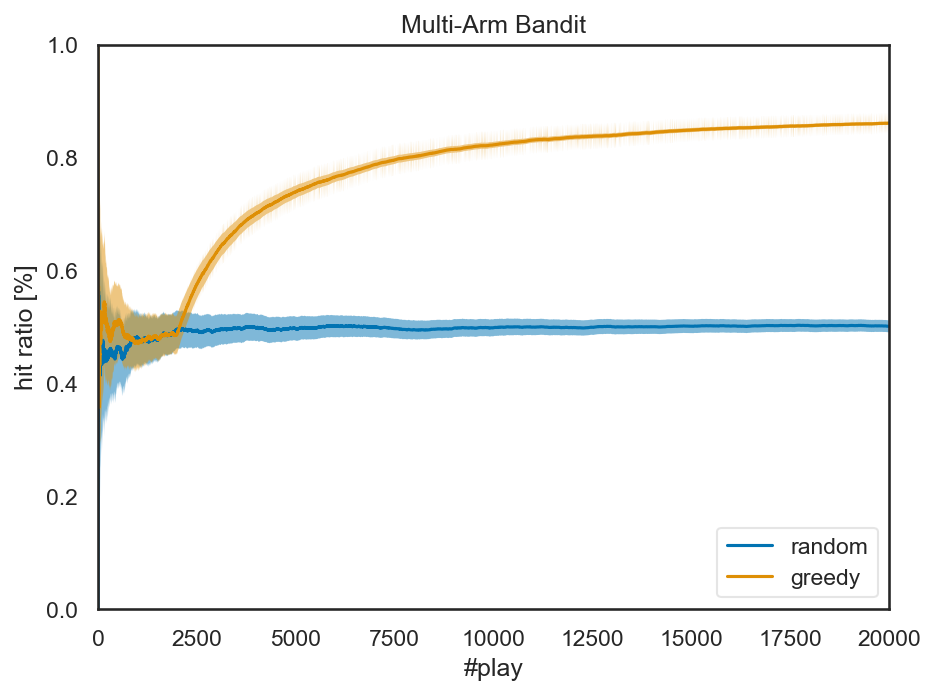

In [11]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.fill_between(
    xs,
    E_greedy - S_greedy * 3.0,
    E_greedy + S_greedy * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_greedy, label="greedy")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

上記の結果を見てみると、一番当たっている物を回す、という戦略はそれほど悪くはないように見える。実際、最終的な報酬は、最も当たりやすいスロットの当たり確率である{glue:text}`best_ratio:.2f`に近づいている。

しかし、最初の10%を回した時点の当たり確率の推定値にその後の報酬が強く依存する上、10%の回数はランダムに回すことから、そこまでで得られる報酬は有意には増加しない。

今回はスロットの当たり確率にそれなりに差があるため、全体の試行回数の10%である2000回程度で、一番当たるスロットがどれかが判明するが、実際には当たり確率が非常に近い場合もあり、貪欲法には依然改善の余地がある。

## $\varepsilon$-greedy法

$\varepsilon$-greedy法は、とある定数$0 < \varepsilon < 1$について、$\varepsilon$の確率でランダムにスロットを選び、$1 - \varepsilon$の確率で一番当たっているスロットを回す、という方法である。

一例として$\varepsilon=0.1$の場合には、先ほどランダムに10%の試行回数をバーンインに用いたものとそれほど変わらないように思える。

しかし、最初の10%を完全にランダムに回してしまうと、本当はもう少し早い段階で一番当たりそうなスロットが判明しているかもしれないのに、それを無視してしまうことになる。そのため、現在分かっている情報をできるだけ有効活用しよう、というのが$\varepsilon$-greedy法の考え方である。

通常、試行回数が増えれば増えるほど、各スロットの当たり確率の推定値が真値に近づいていくので、$\varepsilon$の値は、試行回数とともに徐々に小さくしていくことが多い。以下の実装では、$\varepsilon=0.5$を初期値とし、最終{glue:}`n_play`回の時に$\varepsilon=0.001$となるように等比数列的に$\varepsilon$の値を下げていくことにする。

In [12]:
e0 = 0.5
e1 = 0.001
e_scale = np.exp((np.log(e1) - np.log(e0)) / (n_play - 1))
epsilon = e0

history = []
n_hit_of_arm = [0] * len(arms)
n_play_of_arm = [0] * len(arms)
for i in range(n_play):
    u = np.random.uniform(0.0, 1.0)
    if u < epsilon:
        k = np.random.randint(0, n_arms)
    else:
        rs = [(h / p if p != 0 else 1.0) for h, p in zip(n_hit_of_arm, n_play_of_arm)]
        k = np.argmax(rs)

    if arms[k].roll():
        history.append(1.0)
        n_hit_of_arm[k] += 1
    else:
        history.append(0.0)

    n_play_of_arm[k] += 1
    epsilon *= e_scale

history = np.array(history)
accum = np.cumsum(history)
E_eps = accum / xs
S_eps = np.sqrt((history - E_eps) ** 2.0 / xs)

In [13]:
glue("eps_ratio", E_eps[-1], display=False)

**結果: $\varepsilon$-greedy法**

- 当たり確率: {glue:text}`eps_ratio:.3f`

以下には得られた平均報酬の比較を示す。

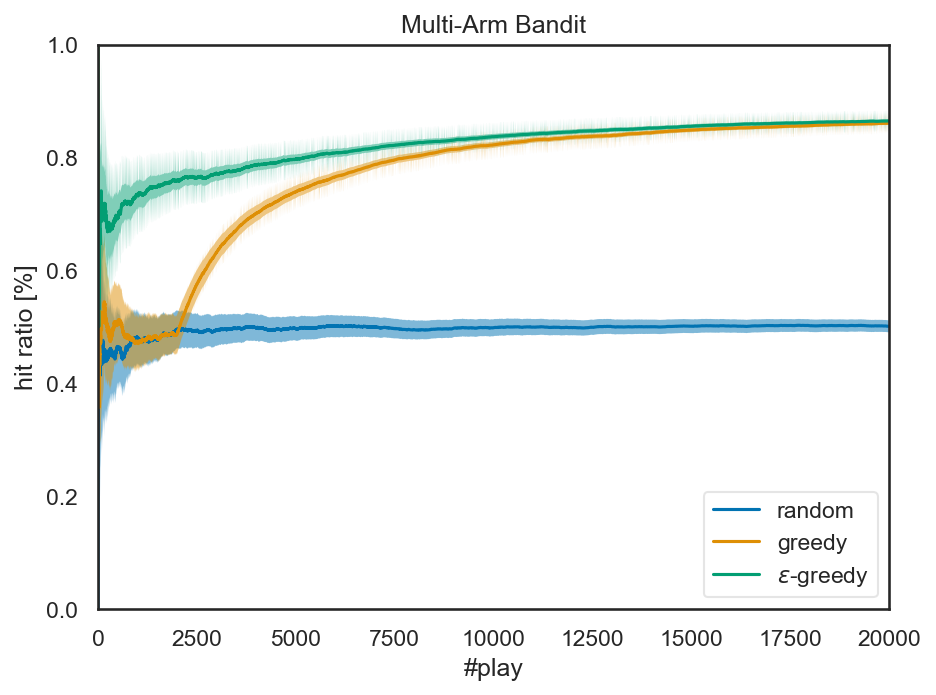

In [14]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.fill_between(
    xs,
    E_greedy - S_greedy * 3.0,
    E_greedy + S_greedy * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_greedy, label="greedy")

ax.fill_between(
    xs,
    E_eps - S_eps * 3.0,
    E_eps + S_eps * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_eps, label="$\epsilon$-greedy")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

このように、ちょっとした工夫を加えるだけで、かなり早い段階から最大の当たり確率である{glue:text}`best_ratio:.2f`に近い当たり確率が得られていることが分かる。

### ソフトマックス探索

$\varepsilon$-greedy法でも十分に良い結果が得られているが、探査のために完全なランダム行動を取る、という点には、まだ改善の余地がある。

例えば、スロットの当たり確率が0.05のスロットも、この時にランダムに選ばれてしまう点はマイナスである。

そこで、ランダムな探査の代わりに、現在の推定当たり確率から求まる評価関数によって、探査行動の選択を考える。このような評価関数の一つにソフトマックス関数がある。このようなソフトマックス関数を使って評価関数を定義する手法を**ソフトマックス探索**あるいは**Bolzmann探索**と呼ぶ。

ソフトマックス関数は[深層学習による機械分類](sec:deep-learning)の際にも紹介した。今回は、$i$番目のスロットに対して求まっている当たり確率の期待値が$x_i$であるとしたときに、スロットの評価値$v_i$を以下のように定義する。

$$
v_i = \frac{e^{x_i}}{\sum_{i=1}^N e^{x_i}}
$$

ソフトマックス関数により得られる評価値は0から1の間の実数を取り、全てのスロットの評価値の合計は1となる。この時、仮に当たり確率の期待値が0であっても、ある程度の割合で選択され、一方で、確率としては、より当たり確率が高いものを相対的に多く選ぶという意味で、ランダム性と当たり確率の利用のバランスが良い。

In [15]:
def softmax(x):
    """ソフトマックス関数"""
    x = x - np.max(x, axis=0)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [16]:
history = []
n_hit_of_arm = [0] * len(arms)
n_play_of_arm = [0] * len(arms)
for i in range(n_play):
    rs = [(h / p if p != 0 else 1e5) for h, p in zip(n_hit_of_arm, n_play_of_arm)]
    rs = softmax(rs)
    k = np.argmax(rs)

    if arms[k].roll():
        history.append(1.0)
        n_hit_of_arm[k] += 1
    else:
        history.append(0.0)

    n_play_of_arm[k] += 1

history = np.array(history)
accum = np.cumsum(history)
E_smax = accum / xs
S_smax = np.sqrt((history - E_smax) ** 2.0 / xs)

In [17]:
glue("softmax_ratio", E_smax[-1], display=False)

**結果: ソフトマックス探索**

- 当たり確率: {glue:text}`softmax_ratio:.3f`

以下には得られた平均報酬の比較を示す。

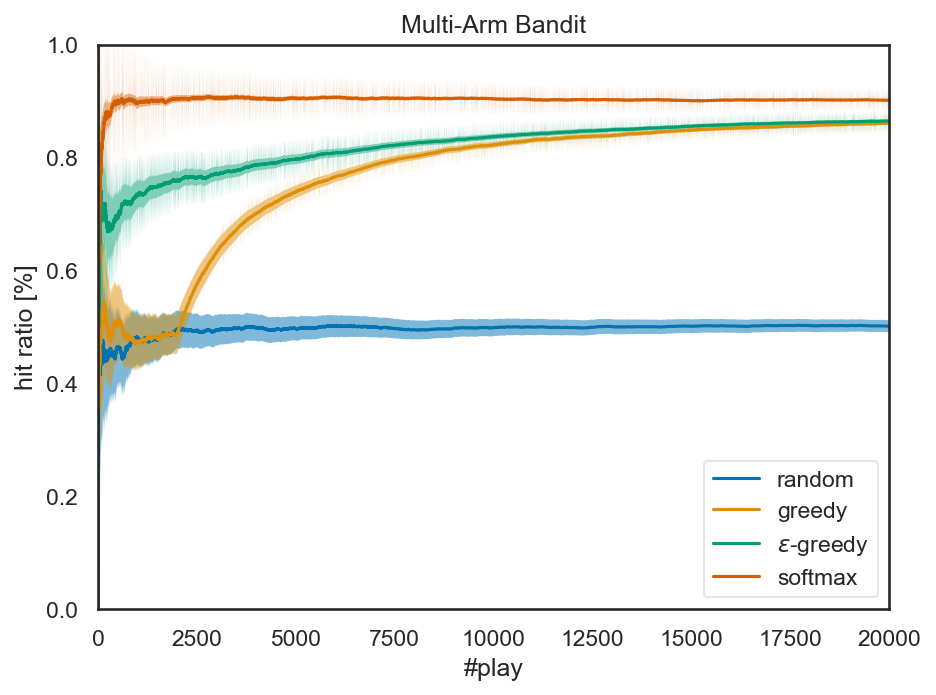

In [18]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.fill_between(
    xs,
    E_greedy - S_greedy * 3.0,
    E_greedy + S_greedy * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_greedy, label="greedy")

ax.fill_between(
    xs,
    E_eps - S_eps * 3.0,
    E_eps + S_eps * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_eps, label="$\epsilon$-greedy")

ax.fill_between(
    xs,
    E_smax - S_smax * 3.0,
    E_smax + S_smax * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_smax, label="softmax")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

上記の結果から、十分に試行回数が多いときには$\varepsilon$-greedy法とソフトマックス法にはそれほど差がないが、ソフトマックス法は**試行回数が少ない場合でも、安定して高い平均報酬が得られている**ことが分かる。

## Upper Confidence Bound (UCB)

先ほどのソフトマックス探索は、多腕バンディット問題のような、各試行によって当たり確率が変化しないような問題に対しては高い性能を示すことが知られているが、その時々で当たり確率が変動するような対象に対しては、安定して作用しないこと知られている。

また、ソフトマックス法はソフトマックス関数により得られた次の試行を選ぶための確率密度分布が経験的に良い値になることを利用している。だが、ソフトマックス関数を適用する前の現在の推定当たり確率に適当なスケールをかけ算する余地があり、どの程度のスケールでソフトマックス関数を計算するのが最適なのかは問題に依存する。

このようなソフトマックス法の経験的な部分を、より理論的に補った手法に**UCB値を用いる手法** {cite}`auer2002finite`がある。UCB値にはいくつかの式が知られているが、最も一般的なUCB1は以下の式で表わされる。

$$
\text{UCB1}_i = \frac{n_{i,{\rm hit}}}{n_{i,{\rm play}}} + \sqrt{\frac{2 \log(n_{\rm total})}{n_{i, {\rm play}}}}
$$

この式で$n_{i,{\rm hit}}$と$n_{i,{\rm play}}$は、評価したいアームの当たり回数と試行回数、$n_{\rm total}$は全アームの試行回数の合計を表わす。

UCB1値の第１項は単純なアームの当たり確率を表わし、第２項はその推定値にどの程度の偏り(=バイアス)が含まれているかを表わしている。

この式のポイントは他のアームが回される、という行動によってバイアスを表わす第2項が変化する、という点で、推定値が高いか、あるいは偏りが大きく、推定値の信頼性が低いアームをより多く回すという戦略を上手く表わしている。

In [19]:
history = []
n_hit_of_arm = [0] * len(arms)
n_play_of_arm = [0] * len(arms)
for i in range(n_play):
    if min(n_play_of_arm) == 0:
        k = np.random.choice([j for j, n in enumerate(n_hit_of_arm) if n == 0])
    else:
        rs = [(h / p if p != 0 else 1e5) for h, p in zip(n_hit_of_arm, n_play_of_arm)]
        bws = np.sqrt(2.0 * np.log(i) / np.array(n_play_of_arm))
        ucb = rs + bws
        k = np.argmax(ucb)

    if arms[k].roll():
        history.append(1.0)
        n_hit_of_arm[k] += 1
    else:
        history.append(0.0)

    n_play_of_arm[k] += 1

history = np.array(history)
accum = np.cumsum(history)
E_ucb = accum / xs
S_ucb = np.sqrt((history - E_ucb) ** 2.0 / xs)

In [20]:
glue("ucb_ratio", E_ucb[-1], display=False)

**結果: UCB1**

- 当たり確率: {glue:text}`ucb_ratio:.3f`

以下には得られた平均報酬の比較を示す。

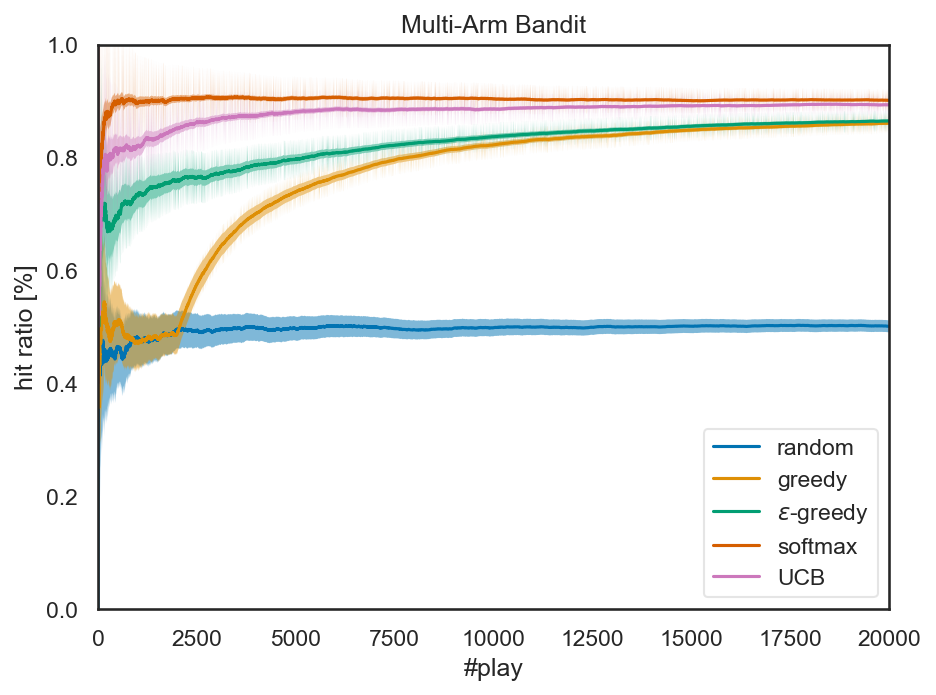

In [21]:
fig, ax = plt.subplots()

ax.fill_between(
    xs,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_rand, label="random")

ax.fill_between(
    xs,
    E_greedy - S_greedy * 3.0,
    E_greedy + S_greedy * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_greedy, label="greedy")

ax.fill_between(
    xs,
    E_eps - S_eps * 3.0,
    E_eps + S_eps * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_eps, label="$\epsilon$-greedy")

ax.fill_between(
    xs,
    E_smax - S_smax * 3.0,
    E_smax + S_smax * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_smax, label="softmax")

ax.fill_between(
    xs,
    E_ucb - S_ucb * 3.0,
    E_ucb + S_ucb * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(xs, E_ucb, label="UCB")

ax.set_xlim([0, n_play])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

plt.legend(loc="lower right", facecolor="white", framealpha=0.5)
plt.tight_layout()
plt.show()

上記のようにUCB1は多腕バンディット問題のような、状態変化が少ない問題においてはソフトマックス法に劣った結果となっているが、**モデルを決定するパラメータがない**点や、状態変化が起こるモデルへの有用性が高い。

この点については、以後の[Q学習](sec:q-learning)の節などで各自で確認してみてほしい。

## 練習問題

- UCBにはいくつかの種類があり、本資料で紹介したものはUCB1と呼ばれる。UCB2やUCB1-tunedと呼ばれる評価関数について調査し、その性能をUCB1と比較せよ。

## 参考文献

```{bibliography}
:filter: docname in docnames
```